## Домашняя работа №6  
Деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент.

In [73]:
#подключение всех нужных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# импортирование из sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    confusion_matrix,
    brier_score_loss,
)
# Зафиксируем random state
RANDOM_STATE = 42

# Зафиксируем путь
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: D:\_Programming\VS_Code\mirea-dpo-aie\homeworks\HW06\artifacts


In [74]:
# Вспомогательные функции для эксперимента.

# Здесь нет “обучения” – только сервисные вещи:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# def plot_confusion(y_true, y_pred, title: str):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(5, 4))
#     plt.imshow(cm)
#     plt.title(title)
#     plt.xlabel("pred")
#     plt.ylabel("true")
#     plt.xticks([0, 1])
#     plt.yticks([0, 1])
#     for (i, j), v in np.ndenumerate(cm):
#         plt.text(j, i, str(v), ha="center", va="center")
#     plt.savefig("artifacts/figures/"+title+"_ConfusionMatrix.png")
#     plt.show()

def plot_confusion(model, X_test, y_test, title: str):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.savefig("artifacts/figures/"+title+"_ConfusionMatrix.png")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig("artifacts/figures/"+title+"_RocCurve.png")
    plt.show()
     

In [75]:
# импортирование датафрейма
df = pd.read_csv("S06-hw-dataset-02.csv")

# выведекм несколько первыйх столбцов, чтобы убедиться, что датасет загружен
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [76]:
# выведем основную информацию по столбцам
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [77]:
# выведем базовые описательные статистики
df.iloc[:,1:].describe()
display(df.iloc[0])

id         1.000000
f01       -0.149235
f02       -2.826966
f03       -0.522901
f04       -4.198449
f05        1.364943
f06        0.815043
f07       -1.195518
f08       -1.932232
f09        2.396353
f10        1.121683
f11       -0.332250
f12        0.303750
f13        2.439315
f14        3.905690
f15       -0.679945
f16       -1.847890
f17       -1.450850
f18       -0.523963
f19       -2.203766
f20        1.717017
f21       -0.467238
f22       -5.418752
f23        5.115531
f24        0.951900
f25        0.085200
f26        0.304588
f27        0.206599
f28        0.293322
f29       -0.159323
f30        0.448015
f31        0.572745
f32        0.149916
f33        0.878392
f34       -0.679733
f35        1.412751
x_int_1    0.421883
x_int_2    9.217167
target     1.000000
Name: 0, dtype: float64

In [78]:
# Посмотрим на распределение целевого признака
df['target'].value_counts(normalize=True)

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

In [79]:
# Проверим типы и пропуски
print(df.dtypes.unique())
print(df.isna().sum().sum())


[dtype('int64') dtype('float64')]
0


### Вывод  
Как мы можем заметить в датафрейме нет пропусков и присутствуют лишь два типа данных: int и float.  
Распределение таргета: 0 - 73.7%; 1 - 26.3%

In [80]:
# Подготовка признаков и таргета
y = df['target']
X = df.iloc[:,1:-1]


In [81]:

# Делим наши данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE, stratify = y)

Фиксированный сид нужен для возможности воспроизведения результата.   
Стратификация нужна, чтобы отношение значений таргета сохранялось в тренировочном и тестовом дата сете (чтобы, например, в тренировочных данных не были одни нули)

In [82]:
# - results: список словарей с метриками на тесте
# - best_models: сюда складываем обученные лучшие модели (чтобы потом их диагностировать/сохранить)
# - search_summaries: сюда складываем лучшие параметры подбора и CV-оценку

# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе


=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===
{'accuracy': 0.7375, 'f1': 0.0, 'roc_auc': 0.5, 'model': 'DummyClassifier'}


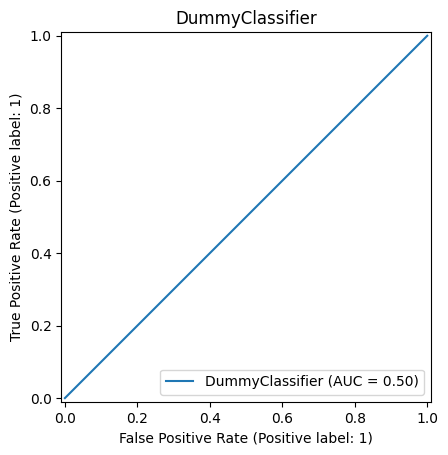

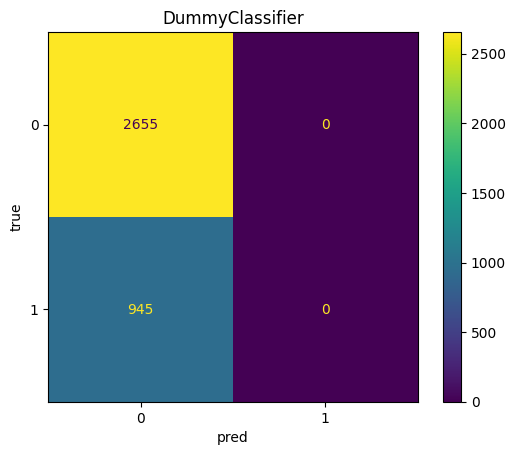

In [83]:
# Построим одну baseline модель на основе DummyClassifier
dummy = DummyClassifier(strategy="most_frequent", random_state = RANDOM_STATE)
dummy.fit(X_train, y_train)

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===")
results.append(evaluate_on_test(dummy,X_test,y_test,"DummyClassifier"))
print(results[-1])
best_models["Dummy(most_frequent)"] = dummy


# Построение ROC кривой для DummyClssifier
plot_roc(dummy, X_test,y_test,"DummyClassifier")


# Построение Confusion Matrix для DummyClssifier
plot_confusion(dummy, X_test,y_test,"DummyClassifier")


### Вывод:  
* Точность равна доле нулей в датасете  
* F1-score равен 0, т.к. модель всегда предсказывала 0  
* ROC-AUC равна 0.5, что свидительствует о "рандомном" выборе значения  

Fitting 5 folds for each of 6 candidates, totalling 30 fits
=== Оценка результата CV ===
{'best_params': {'logreg__C': 1000.0}, 'best_cv_roc_auc': 0.8034448981095345} 

=== Бейзлайн (Pipeline[StandardScaler + LogisticRegression]) – качество на test ===
{'accuracy': 0.8119444444444445, 'f1': 0.5606748864373783, 'roc_auc': 0.7976942775436185, 'model': 'LogisticRegression'}


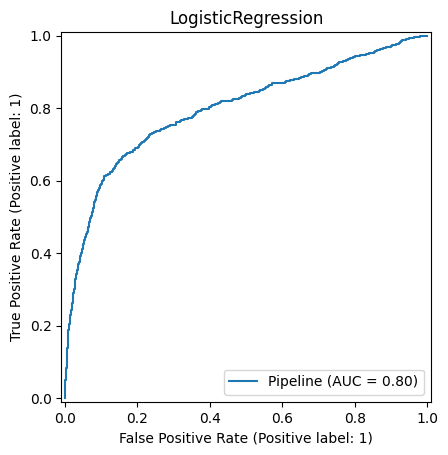

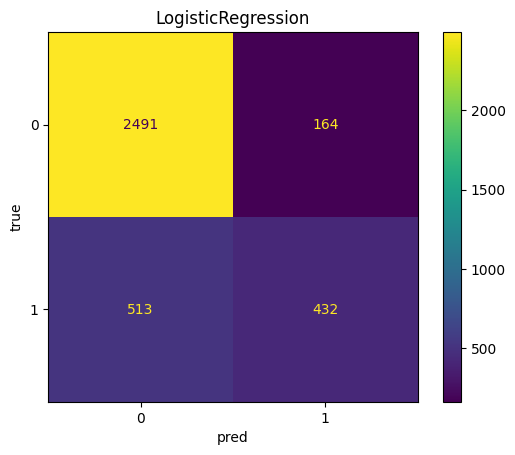

In [84]:
# Построим pipeline с логистической регрессией и масштабированием признаков 
log_reg_pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("logreg", LogisticRegression(l1_ratio=0,max_iter=1000,C=1.0,random_state=RANDOM_STATE))
])

# Подберем параметр C через GridSearchCV
log_reg_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
}

log_reg_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_grid,
    scoring="roc_auc", 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)

log_reg_search.fit(X_train, y_train)

print("=== Оценка результата CV ===")
search_summaries["LogReg(scaled)"] = {
    "best_params": log_reg_search.best_params_,
    "best_cv_roc_auc": float(log_reg_search.best_score_),
}
print(search_summaries["LogReg(scaled)"],"\n")


# Берём лучшую найденную модель
best_log_reg = log_reg_search.best_estimator_
best_models["LogReg(scaled)"] = best_log_reg
# Оцениваем на test
print("=== Бейзлайн (Pipeline[StandardScaler + LogisticRegression]) – качество на test ===")
results.append(evaluate_on_test(best_log_reg,X_test,y_test,"LogisticRegression"))
print(results[-1])
# Построение ROC кривой для Regression Model
plot_roc(best_log_reg, X_test,y_test,"LogisticRegression")

# Построение Confusion Matrix для Regression Model
plot_confusion(best_log_reg, X_test,y_test,"LogisticRegression")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
=== Оценка результата CV ===
{'best_params': {'max_depth': 10, 'min_samples_leaf': 20}, 'best_cv_roc_auc': 0.8366688539987104} 

=== Decision Tree – качество на test ===
{'accuracy': 0.8336111111111111, 'f1': 0.6515415939499709, 'roc_auc': 0.8373517073705398, 'model': 'DecisionTree'}


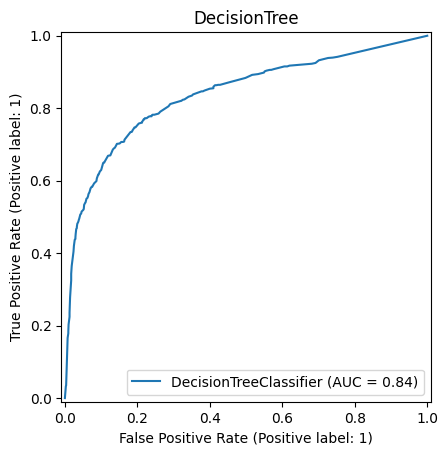

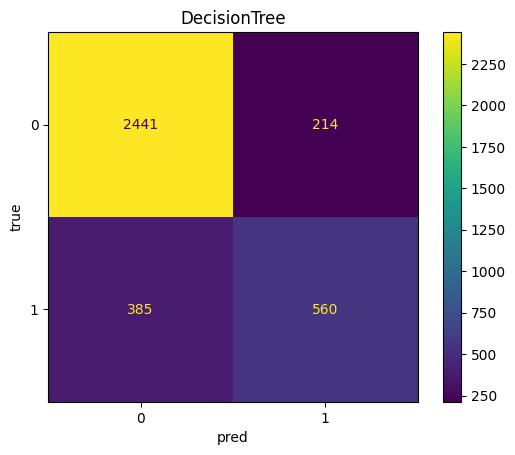

In [85]:
# Построим модель DecisionTreeClassifier
dec_tree=DecisionTreeClassifier(random_state=RANDOM_STATE)

# Подберем параметр C через GridSearchCV
dec_tree_grid = {
    "max_depth": [None, 3, 5, 8, 10],
    "min_samples_leaf": [1, 5, 10, 15, 20],
}

dec_tree_search = GridSearchCV(
    estimator=dec_tree,
    param_grid=dec_tree_grid,
    scoring="roc_auc", 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)


dec_tree_search.fit(X_train, y_train)

print("=== Оценка результата CV ===")
search_summaries["DecisionTree"] = {
    "best_params": dec_tree_search.best_params_,
    "best_cv_roc_auc": float(dec_tree_search.best_score_),
}
print(search_summaries["DecisionTree"],"\n")


# Берём лучшую найденную модель
best_dec_tree = dec_tree_search.best_estimator_
best_models["DecisionTree"] = best_dec_tree
# Оцениваем на test
print("=== Decision Tree – качество на test ===")
results.append(evaluate_on_test(best_dec_tree,X_test,y_test,"DecisionTree"))
print(results[-1])
# Построение ROC кривой для DecisionTreeClassifier
plot_roc(best_dec_tree, X_test,y_test,"DecisionTree")

# Построение Confusion Matrix для DecisionTreeClassifier
plot_confusion(best_dec_tree, X_test,y_test,"DecisionTree")


In [ ]:
# Построим модель RandomForest
rand_forest=RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    oob_score=False,
    random_state=RANDOM_STATE)

# Подберем параметр C через GridSearchCV
rand_forest_grid = {
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 7, 15],
    "max_features": ["sqrt", 0.5],
}

rand_forest_search = GridSearchCV(
    estimator=rand_forest,
    param_grid=rand_forest_grid,
    scoring="roc_auc", 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)


rand_forest_search.fit(X_train, y_train)

print("=== Оценка результата CV ===")
search_summaries["RandomForest"] = {
    "best_params": rand_forest_search.best_params_,
    "best_cv_roc_auc": float(rand_forest_search.best_score_),
}
print(search_summaries["RandomForest"],"\n")


# Берём лучшую найденную модель
best_rand_forest = rand_forest_search.best_estimator_
best_models["RandomForest"] = best_rand_forest
# Оцениваем на test
print("=== Random Forest – качество на test ===")
results.append(evaluate_on_test(best_rand_forest,X_test,y_test,"RandomForest"))
print(results[-1])
# Построение ROC кривой для RandomForest
plot_roc(best_rand_forest, X_test,y_test,"RandomForest")

# Построение Confusion Matrix для RandomForest
plot_confusion(best_rand_forest, X_test,y_test,"RandomForest")


Fitting 5 folds for each of 18 candidates, totalling 90 fits


Fitting 5 folds for each of 27 candidates, totalling 135 fits
=== Оценка результата CV ===
{'best_params': {'learning_rate': 0.05, 'max_depth': None, 'max_leaf_nodes': 63}, 'best_cv_roc_auc': 0.9316701338860615} 

=== Random Forest – качество на test ===
{'accuracy': 0.9052777777777777, 'f1': 0.802547770700637, 'roc_auc': 0.9312444324873704, 'model': 'HistGradientBoosting'}


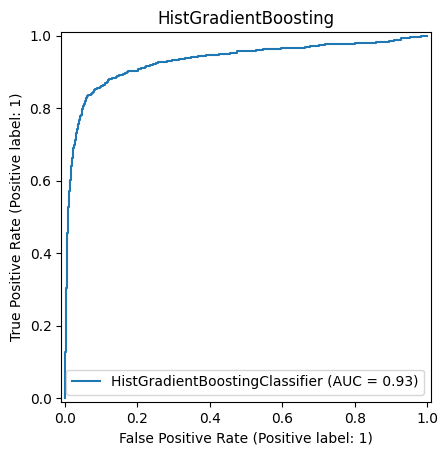

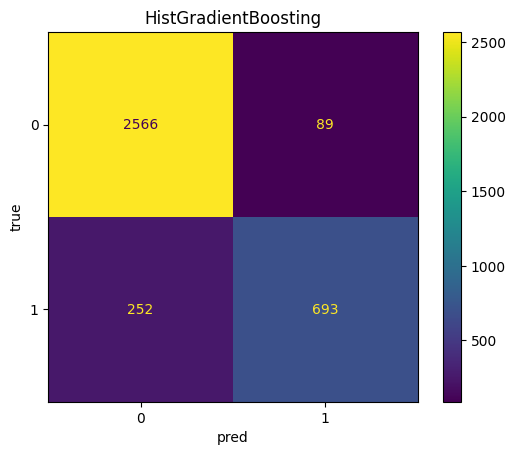

In [ ]:
# Построим модель Gradient Boosting
hgb=HistGradientBoostingClassifier(
    early_stopping=True,
    random_state=RANDOM_STATE)

# Подберем параметр C через GridSearchCV
hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_grid,
    scoring="roc_auc", 
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score=True
)


hgb_search.fit(X_train, y_train)

print("=== Оценка результата CV ===")
search_summaries["HistGradientBoosting"] = {
    "best_params": hgb_search.best_params_,
    "best_cv_roc_auc": float(hgb_search.best_score_),
}
print(search_summaries["HistGradientBoosting"],"\n")


# Берём лучшую найденную модель
best_hgb = hgb_search.best_estimator_
best_models["HistGradientBoosting"] = best_hgb
# Оцениваем на test
print("=== Random Forest – качество на test ===")
results.append(evaluate_on_test(best_hgb,X_test,y_test,"HistGradientBoosting"))
print(results[-1])
# Построение ROC кривой для Gradient Boosting
plot_roc(best_hgb, X_test,y_test,"HistGradientBoosting")

# Построение Confusion Matrix для Gradient Boosting
plot_confusion(best_hgb, X_test,y_test,"HistGradientBoosting")


In [ ]:
# Сводка результатов в таблицу.
df_result = pd.DataFrame(results)

# сортировка: roc_auc (если есть) иначе accuracy
df_sorted = df.copy()
df_sorted = df_sorted.sort_values(["roc_auc", "accuracy"], ascending=False)

df_sorted

,accuracy,f1,roc_auc,model
4,0.905278,0.802548,0.931244,HistGradientBoosting
3,0.892222,0.761084,0.928887,RandomForest
2,0.833611,0.651542,0.837352,DecisionTree
1,0.811944,0.560675,0.797694,LogisticRegression
0,0.737500,0.000000,0.500000,DummyClassifier


In [ ]:
# Сохранение артефактов эксперимента в artifacts/.

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


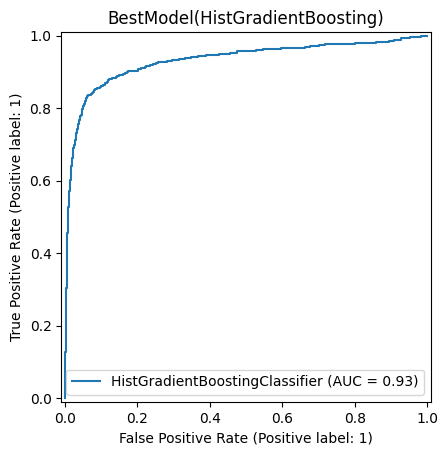

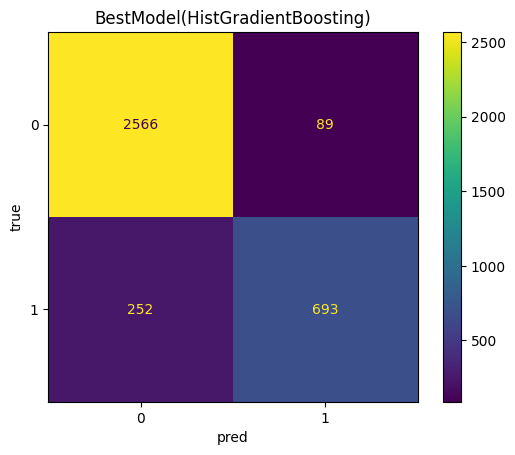

In [ ]:
# Выбираем лучшую модель

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()


# Построение ROC кривой для лучшей модели
plot_roc(best_hgb, X_test,y_test,title=f"BestModel({best_label})")

# Построение Confusion Matrix для лучшей модели
plot_confusion(best_hgb, X_test,y_test,title=f"BestModel({best_label})")

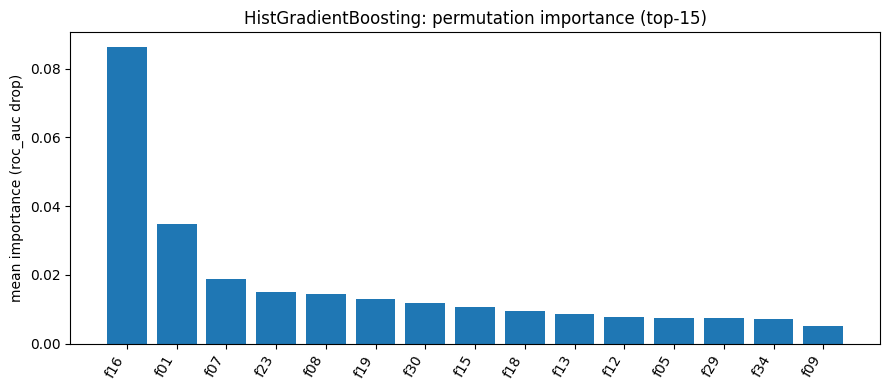

In [ ]:
# Permutation importance на тесте (top-15).

scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [list(X.columns)[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()